# Group 28: April Kim, Immanuel Ponminissery, Sujay Chebbi
# Ratings Classification

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import re
pd.options.mode.chained_assignment = None  # default='warn'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Question 1
### Read in data

In [2]:
labels = pd.read_csv('labels.txt', sep = '\t', header = None)
labels.columns = ['turk', 'url', 'category']
labels

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
...,...,...,...
92716,AFHMR93GDJCGT,http://zz868.com,G
92717,A13F119AMOA54H,http://zzx.cc,X
92718,A1S0C0EB7A6FFM,http://zzx.cc,P
92719,A21US576U8SCO4,http://zzx.cc,G


In [3]:
gold = pd.read_csv('gold.txt', sep = '\t', header = None)
gold.columns = ['url', 'category']
gold

,url,category
0,http://0800-horoscope.com,G
1,http://18games.net,X
2,http://1pixelout.net,G
3,http://1porno.com/004/teens/index.html,X
4,http://1stpussy.com/005/16/index.html,X
...,...,...
1512,http://zipcodez.com,G
1513,http://zml.com,P
1514,http://zonezero.com,G
1515,http://zooped.com,R


## Question 2
### Split into two DataFrames

In [4]:
gold_mask = labels['url'].isin(gold['url'])

In [5]:
labels_on_gold = labels[gold_mask]
labels_on_gold

,turk,url,category
245,A1253FXHCZ9CWM,http://0800-horoscope.com,G
246,A153PKAL7OAY36,http://0800-horoscope.com,G
247,A1FV9SAPL5C6KY,http://0800-horoscope.com,G
248,A1JTOT0DWM6QGL,http://0800-horoscope.com,G
249,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G
...,...,...,...
91766,A35CBDDGBM7T6E,http://yousendit.com,G
91767,A3J86MK3VIE6ST,http://yousendit.com,G
91768,A4GP97LAQCCHJ,http://yousendit.com,G
91769,AAQNUEUU7H1Y5,http://yousendit.com,G


In [6]:
labels_unknown = labels[~gold_mask]
labels_unknown

,turk,url,category
0,A1OT3A29R9N1DG,http://000.cc,P
1,A1PXXEOGQ76RNJ,http://000.cc,G
2,A1PXXEOGQ76RNJ,http://000.cc,G
3,A21US576U8SCO4,http://000.cc,G
4,A2LGX47NN7C5D3,http://000.cc,G
...,...,...,...
92716,AFHMR93GDJCGT,http://zz868.com,G
92717,A13F119AMOA54H,http://zzx.cc,X
92718,A1S0C0EB7A6FFM,http://zzx.cc,P
92719,A21US576U8SCO4,http://zzx.cc,G


## Question 3
### Compute accuracies of turks

In [7]:
merge = labels_on_gold.merge(gold, 
                             left_on = 'url', 
                             right_on = 'url', 
                             suffixes = ['_labels','_gold'])
#merge

In [8]:
merge['accurate'] = merge['category_labels'] == merge['category_gold']
merge[:10]

,turk,url,category_labels,category_gold,accurate
0,A1253FXHCZ9CWM,http://0800-horoscope.com,G,G,True
1,A153PKAL7OAY36,http://0800-horoscope.com,G,G,True
2,A1FV9SAPL5C6KY,http://0800-horoscope.com,G,G,True
3,A1JTOT0DWM6QGL,http://0800-horoscope.com,G,G,True
4,A1PXXEOGQ76RNJ,http://0800-horoscope.com,G,G,True
5,A21US576U8SCO4,http://0800-horoscope.com,G,G,True
6,A22C0PJUBFJTI0,http://0800-horoscope.com,G,G,True
7,A270HOAHEVIFW0,http://0800-horoscope.com,G,G,True
8,A2EG8FHODTEV63,http://0800-horoscope.com,R,G,False
9,A2LM400F4F0V0M,http://0800-horoscope.com,G,G,True


In [9]:
rater_goodness = merge.groupby(['turk'])['accurate'].agg(['count','mean'])
rater_goodness.columns = ['number of ratings', 'average correctness']
rater_goodness

,number of ratings,average correctness
turk,,
A112DVP1KG4QZU,1,1.000000
A1253FXHCZ9CWM,29,0.517241
A12CY1Q7XKJJDE,1,1.000000
A12RE8G66WTO8B,20,0.750000
A12Y1GTGIQDGRA,3,0.333333
...,...,...
AYWOBMTEGFVVI,1,0.000000
AZ1S5BIG5R6P6,35,0.714286
AZSDW7JJL5VA7,100,0.680000


## Question 4
### Odds ratios

In [10]:
def odds(p):
    odds = p / (1.001 - p)
    return odds

In [11]:
rater_goodness['odds'] = rater_goodness['average correctness'].map(odds)
rater_goodness

,number of ratings,average correctness,odds
turk,,,
A112DVP1KG4QZU,1,1.000000,1000.000000
A1253FXHCZ9CWM,29,0.517241,1.069214
A12CY1Q7XKJJDE,1,1.000000,1000.000000
A12RE8G66WTO8B,20,0.750000,2.988048
A12Y1GTGIQDGRA,3,0.333333,0.499251
...,...,...,...
AYWOBMTEGFVVI,1,0.000000,0.000000
AZ1S5BIG5R6P6,35,0.714286,2.491281
AZSDW7JJL5VA7,100,0.680000,2.118380


## Question 5
### Most accurate turks

In [12]:
mask_20 = rater_goodness['number of ratings'] >= 20

In [13]:
rater_goodness[mask_20].sort_values(by = 'average correctness', ascending = False)[:10]

,number of ratings,average correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


## Question 6
### Ratings count versus accuracy

Text(0.5, 1.0, 'Accuracy vs Volume')

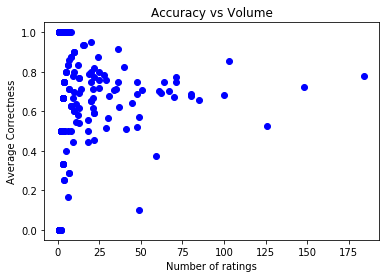

In [14]:
plot(rater_goodness['number of ratings'], rater_goodness['average correctness'], 
     marker = 'o', 
     color = 'blue', 
     linestyle = 'None')
xlabel('Number of ratings')
ylabel('Average Correctness')
title('Accuracy vs Volume')

#### Average correctness of turks plotted against respective number of ratings. As the number of ratings for gold URLs increases, a turk's average correctness approaches approximately 75%.

## Question 7
### Overall predicted odds

In [15]:
rater_percentile = pd.qcut(rater_goodness['number of ratings'].rank(method = 'first'), 
                           4, 
                           labels = ['0-25', '25-50', '50-75', '75-100'])
rater_goodness['count percentiles'] = rater_percentile
#rater_goodness

In [16]:
mask75 = rater_goodness['count percentiles'] == '75-100'

In [17]:
turks_75 = rater_goodness[mask75]
#turks_75

In [18]:
labels_unknown_odds_75 = labels_unknown.merge(turks_75, 
                                              left_on = 'turk', 
                                              right_on = 'turk')
labels_unknown_odds_75 = labels_unknown_odds_75.sort_values(by = 'url')

In [19]:
labels_unknown_odds_75[:5]

,turk,url,category,number of ratings,average correctness,odds,count percentiles
7272,A21US576U8SCO4,http://0-101.net,G,49,0.571429,1.330229,75-100
31902,A29T6EIMK6R7O0,http://0-101.net,G,21,0.619048,1.620746,75-100
0,A1PXXEOGQ76RNJ,http://000.cc,G,41,0.512195,1.047852,75-100
7265,A21US576U8SCO4,http://000.cc,G,49,0.571429,1.330229,75-100
1,A1PXXEOGQ76RNJ,http://000.cc,G,41,0.512195,1.047852,75-100


In [20]:
overall_odds_75 = labels_unknown_odds_75.groupby(['url', 'category'])[['odds']].agg('prod')
overall_odds_75.columns = ['overall odds_75']

In [21]:
overall_odds_75

overall odds_75
url                         category                 
http://0-101.net            G                2.155963
http://000.cc               G                1.460583
http://0000.jp              G               14.488244
http://000relationships.com G                5.681060
                            P                1.851852
...                                               ...
http://zynga.com            G                3.704611
http://zz868.com            G                1.047852
                            P                1.851852
http://zzx.cc               G                1.330229
                            X                1.620746

[13987 rows x 1 columns]

## Question 8
### Predicted categories

In [22]:
overall_odds_75_remade = overall_odds_75.reset_index(level = 'category')

In [23]:
overall_odds_75_remade = overall_odds_75_remade.sort_values(by = 'overall odds_75', ascending = False)
#overall_odds_75_remade

In [24]:
results_75 = overall_odds_75_remade.groupby(overall_odds_75_remade.index).first()

In [25]:
results_75.columns = ['top category', 'top odds']
results_75

,top category,top odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
...,...,...
http://zwinky.com,G,16.141443
http://zylom.com,G,1.735526
http://zynga.com,G,3.704611


## Question 9
### Predicted categories using more turks

In [26]:
mask25 = rater_goodness['count percentiles'] == '25-50'

In [27]:
mask50 = rater_goodness['count percentiles'] == '50-75'

In [28]:
turks_25 = rater_goodness[mask25 | mask50 | mask75]
#turks_25

In [29]:
labels_unknown_odds_25 = labels_unknown.merge(turks_25, 
                                              left_on = 'turk', 
                                              right_on = 'turk')

In [30]:
labels_unknown_odds_25 = labels_unknown_odds_25.sort_values(by = 'url')
labels_unknown_odds_25[:5]

,turk,url,category,number of ratings,average correctness,odds,count percentiles
7529,A21US576U8SCO4,http://0-101.net,G,49,0.571429,1.330229,75-100
44598,A29T6EIMK6R7O0,http://0-101.net,G,21,0.619048,1.620746,75-100
0,A1OT3A29R9N1DG,http://000.cc,P,8,0.500000,0.998004,50-75
16054,A2LGX47NN7C5D3,http://000.cc,G,3,1.000000,1000.000000,25-50
16806,AHY98D5P05XIV,http://000.cc,G,10,0.600000,1.496259,50-75


In [31]:
overall_odds_25 = labels_unknown_odds_25.groupby(['url', 'category'])[['odds']].agg('prod')

In [32]:
overall_odds_25.columns = ['overall odds_25']
overall_odds_25

overall odds_25
url                         category                 
http://0-101.net            G            2.155963e+00
http://000.cc               G            2.181050e+03
                            P            9.980040e-01
http://0000.jp              G            2.877556e+07
http://000relationships.com G            0.000000e+00
...                                               ...
http://zz868.com            G            1.209566e+16
                            P            1.851852e+00
http://zzx.cc               G            1.330229e+00
                            P            9.980040e-01
                            X            1.620746e+00

[17060 rows x 1 columns]

In [33]:
overall_odds_25_remade = overall_odds_25.reset_index(level = 'category')

In [34]:
overall_odds_25_remade = overall_odds_25_remade.sort_values(by = 'overall odds_25', ascending = False)
#overall_odds_25_remade

In [35]:
results_25 = overall_odds_25_remade.groupby(overall_odds_25_remade.index).first()

In [36]:
results_25.columns = ['top category', 'top odds']
results_25

,top category,top odds
url,,
http://0-101.net,G,2.155963e+00
http://000.cc,G,2.181050e+03
http://0000.jp,G,2.877556e+07
http://000relationships.com,P,1.851852e+00
http://000vitamins.com,G,5.014149e+03
...,...,...
http://zwinky.com,P,1.000000e+03
http://zylom.com,G,2.873345e+06
http://zynga.com,G,5.442125e+01


In [37]:
both_results = results_75.merge(results_25, 
                                left_on = 'url', 
                                right_on = 'url',
                                suffixes = ['_75','_25'])

In [38]:
both_results

,top category_75,top odds_75,top category_25,top odds_25
url,,,,
http://0-101.net,G,2.155963,G,2.155963e+00
http://000.cc,G,1.460583,G,2.181050e+03
http://0000.jp,G,14.488244,G,2.877556e+07
http://000relationships.com,G,5.681060,P,1.851852e+00
http://000vitamins.com,G,3.784982,G,5.014149e+03
...,...,...,...,...
http://zwinky.com,G,16.141443,P,1.000000e+03
http://zylom.com,G,1.735526,G,2.873345e+06
http://zynga.com,G,3.704611,G,5.442125e+01


In [39]:
errors = pd.crosstab(both_results['top category_75'], both_results['top category_25'])

In [40]:
errors

top category_25,G,P,R,X
top category_75,,,,
G,8145,699,224,234
P,240,273,48,23
R,23,38,112,35
X,48,6,29,433


In [41]:
print('Category G has a total of', 699 + 224 + 234 + 240 + 23 + 48, 'errors.')
print('Category P has a total of', 240 + 48 + 23 + 699 + 38 + 6, 'errors.' )
print('Category R has a total of', 23 + 38 + 35 + 224 + 48 + 29, 'errors.')
print('Category X has a total of', 48 + 6 + 29 + 234 + 23 + 35, 'errors.')
print('The highest error combination occured in the G row and P column cell, where 699 errors occured.')

Category G has a total of 1468 errors.
Category P has a total of 1054 errors.
Category R has a total of 397 errors.
Category X has a total of 375 errors.
The highest error combination occured in the G row and P column cell, where 699 errors occured.


#### According to the crosstab matrix, 75th percentile and above turks and 25th percentile and above turks rated websites correctly along the diagonal of the matrix. Therefore, errors occur on the off-diagonal. The most errors occured for row G and column P. That is, when the 75th percentile and above turks rated websites as G, and the 25th percentile and above of turks rated websites as P.